In [366]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [367]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [368]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [369]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [370]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [371]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [372]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [373]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [374]:
#View measurement database
measurement_db = pd.read_sql("SELECT * FROM measurement", engine.connect(), index_col="id")
measurement_db

,station,date,prcp,tobs
id,,,,
1,USC00519397,2010-01-01,0.08,65.0
2,USC00519397,2010-01-02,0.00,63.0
3,USC00519397,2010-01-03,0.00,74.0
4,USC00519397,2010-01-04,0.00,76.0
5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...
19546,USC00516128,2017-08-19,0.09,71.0
19547,USC00516128,2017-08-20,NaN,78.0
19548,USC00516128,2017-08-21,0.56,76.0


In [375]:
#view station database
station_db = pd.read_sql("SELECT * FROM station", engine.connect(), index_col="id")
station_db

,station,name,latitude,longitude,elevation
id,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Exploratory Precipitation Analysis

In [376]:
# Find the most recent date in the data set.
recent_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_query
# other ways:
#most_recent = pd.read_sql('SELECT MAX(date) FROM Measurement', engine.connect())
#engine.execute('SELECT MAX(date) FROM Measurement').fetchone()
recent_query

('2017-08-23',)

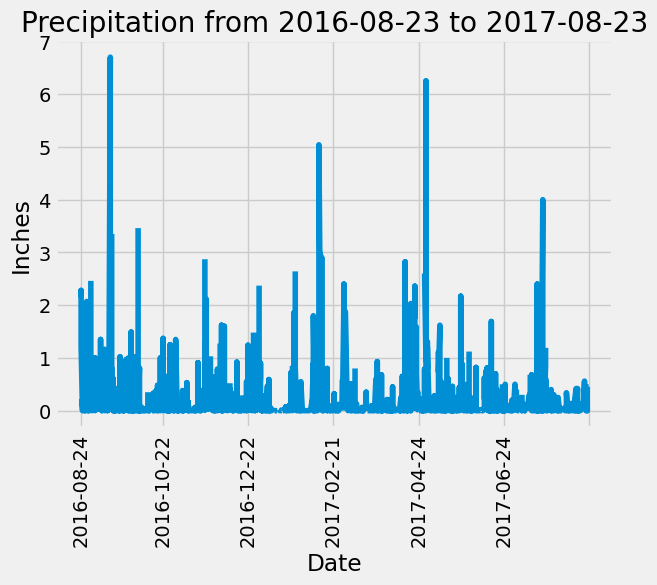

In [377]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = dt.datetime.strptime(recent_query[0],'%Y-%m-%d')

# Calculate the date one year from the last date in data set.
year_ago = most_recent_date - dt.timedelta(days=365)
year_ago #results in datetime.date(2016, 8, 23)

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
one_year_data = session.query(*sel).\
    filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_year_data)
df = df.set_index("date")

# Sort the dataframe by date
df = df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
# set x-axis intervals using mdates 
plt.plot(df)

plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation from 2016-08-23 to 2017-08-23')

interval = mdates.MonthLocator(interval=2)
plt.gca().xaxis.set_major_locator(interval)

plt.xticks(rotation = 90)

plt.show()

In [378]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [379]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).distinct(Measurement.station).count()

C:\Users\grace\AppData\Local\Temp\ipykernel_14624\1927281575.py:2: SADeprecationWarning: DISTINCT ON is currently supported only by the PostgreSQL dialect.  Use of DISTINCT ON for other backends is currently silently ignored, however this usage is deprecated, and will raise CompileError in a future release for all backends that do not support this syntax.
  session.query(Measurement.station).distinct(Measurement.station).count()


9

In [380]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations_counts = session.query(Measurement.station, func.count(Measurement.station)) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()).all()

stations_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [381]:
# store string for most active station bu grabbing from resulting list of dictionaries. 
most_active = stations_counts[0][0]
most_active

'USC00519281'

In [382]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(Measurement.tobs), \
              func.max(Measurement.tobs), \
              func.avg(Measurement.tobs)) \
       .filter(Measurement.station == most_active).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Frequency of Temperatures Ranges for USC00519281')

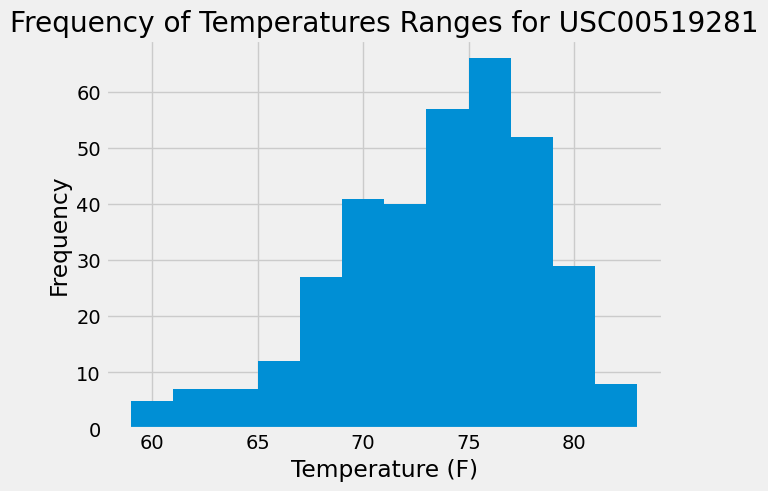

In [383]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_data = session.query(Measurement.tobs) \
                        .filter(Measurement.station == most_active) \
                        .filter(Measurement.date > year_ago) \
                        .all()

# save query results to a pandas dataframe
most_active_df = pd.DataFrame(most_active_data)

#plot histogram with bins=12
plt.hist(most_active_df, bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f"Frequency of Temperatures Ranges for {most_active}")

# Close session

In [384]:
# Close Session
session.close()